In [36]:
import pyredner
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm.notebook import tqdm
from IPython.display import clear_output

# Use GPU if available
pyredner.set_use_gpu(torch.cuda.is_available())
pyredner.render_pytorch.print_timing = False

In [29]:
def gamma_encode(image):
    return image ** (1.0/2.2)

In [11]:
obj_file = 'data/spot/spot.obj'

In [12]:
#loading the obj file with texture and material properties and initializing the camera
target_object = pyredner.load_obj(obj_file, return_objects = True)
camera = pyredner.automatic_camera_placement(target_object, resolution=(256,256))
camera.position = camera.look_at + torch.tensor([0.0, 0.0, -4])

In [13]:
envmap = pyredner.EnvironmentMap(0.7 * torch.ones(1, 1, 3).cuda())

In [14]:
#generating a target scene
target_scene =  pyredner.Scene(camera = camera, objects = target_object, envmap = envmap)

In [15]:
#rendering the target scene
target_args = pyredner.RenderFunction.serialize_scene(scene=target_scene,
                                                      num_samples = 128,
                                                      max_bounces = 2)
render = pyredner.RenderFunction.apply
target_img = render(0, *target_args)

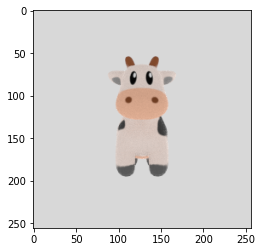

In [31]:
imshow(gamma_encode(target_img).cpu());

In [19]:
pyredner.imwrite(target_img.cpu(), 'results/single_view_optimization/spot/target.png')
target = pyredner.imread('results/single_view_optimization/spot/target.png')
if pyredner.get_use_gpu():
    target = target.cuda(device = pyredner.get_device())

In [20]:
#loading the geometry to compute the uv_index, vertex and normals
material_map, mesh_list, light_map = pyredner.load_obj(obj_file)
for _,mesh in mesh_list:
    mesh_normals = pyredner.compute_vertex_normal(mesh.vertices, mesh.indices)
    computed_uvs = pyredner.compute_uvs(mesh.vertices, mesh.indices)    
uv_vertex, uv_index = computed_uvs

In [21]:
#initializing diffuse, specular and roughness textures and assigning them as materials

diffuse_tex = torch.tensor(\
    np.ones((256, 256, 3), dtype=np.float32) * 0.0,
    requires_grad = True,
    device = pyredner.get_device())


specular_tex = torch.tensor(\
        np.ones((256,256,3),dtype=np.float32) * 0.0,
        requires_grad = True,
        device = pyredner.get_device())


roughness_tex = torch.tensor(\
    np.ones((256, 256, 1), dtype=np.float32) * 0.5,
    requires_grad = True,
    device = pyredner.get_device())

mat = pyredner.Material(diffuse_reflectance=pyredner.Texture(diffuse_tex), 
                       specular_reflectance=pyredner.Texture(specular_tex),
                       roughness=pyredner.Texture(roughness_tex))

In [22]:
#creating the geomerty with initial materials assigned to it

objects = pyredner.Object(vertices = mesh.vertices,
                         indices = mesh.indices,
                         uvs = uv_vertex,
                         uv_indices = uv_index,
                         normals = mesh_normals,
                         material = mat)

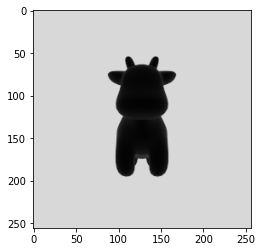

In [33]:
#inital result
scene = pyredner.Scene(camera, objects = [objects], envmap = envmap)
img  = pyredner.render_pathtracing(scene=scene, num_samples=256)
pyredner.imwrite(img.cpu(), 'results/single_view_optimization/spot/initial.png')
imshow(gamma_encode(img).detach().cpu());

In [37]:
optimizer = torch.optim.Adam([diffuse_tex, specular_tex, roughness_tex], lr = 1e-2, weight_decay = 1e-4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(199) Loss: 87.472519


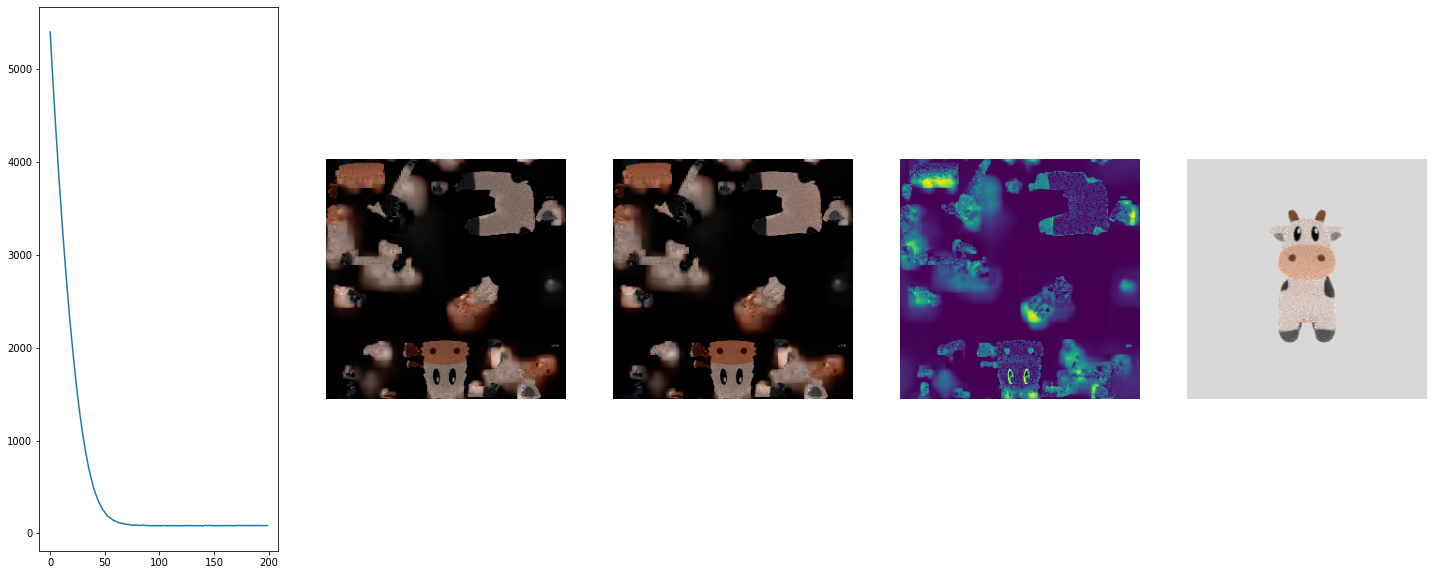

In [38]:
losses = []

for t in tqdm(range(200)):
    print('Iteration: ',t)
    optimizer.zero_grad()
      
    mat.diffuse_reflectance = pyredner.Texture(diffuse_tex)
    mat.specular_reflectance = pyredner.Texture(specular_tex)
    mat.roughness = pyredner.Texture(roughness_tex)
    
    scene = pyredner.Scene(camera, objects = [objects], envmap = envmap)
    args = pyredner.RenderFunction.serialize_scene(\
                                                  scene = scene,
                                                  num_samples = (16,4),
                                                  max_bounces = 1)
    img = render(t+1, *args)
    pyredner.imwrite(img.cpu(),'results/single_view_optimization/spot/iter_{}.png'.format(t))
    
    
    loss = (img - target).pow(2).sum()
    print('Loss:', loss.item())

    loss.backward()
    optimizer.step()
    

    diffuse_tex.data = diffuse_tex.data.clamp(0, 1)
    specular_tex.data = specular_tex.data.clamp(0, 1)
    roughness_tex.data = roughness_tex.data.clamp(1e-5, 1)
    
    clear_output(wait = True)
    print("({:d}) Loss: {:f}".format(t, loss.item()))
    losses.append(loss.item())
    
    plt.figure(figsize=(30, 10))
    plt.subplot(1, 6 ,1)
    plt.plot(losses)
    plt.subplot(1, 6, 2)
    imshow(diffuse_tex.detach().cpu())
    plt.axis('off')
    plt.subplot(1, 6, 3)
    imshow(specular_tex.detach().cpu())
    plt.axis('off')
    plt.subplot(1, 6, 4)
    imshow(roughness_tex.detach().cpu())
    plt.axis('off')
    plt.subplot(1, 6 ,5)
    imshow(gamma_encode(img).detach().cpu())
    plt.axis('off')
    
    plt.show()

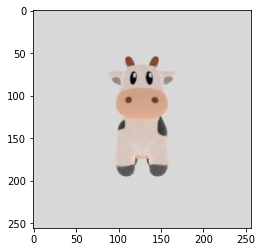

In [40]:
args = pyredner.RenderFunction.serialize_scene(\
                                              scene =scene,
                                              num_samples = 256,
                                              max_bounces = 2)

img = render(200, *args)

pyredner.imwrite(img.cpu(), 'results/single_view_optimization/spot/final.png')
imshow(torch.pow(img,1.0/2.2).detach().cpu())